# Introduction {#introduction}

<a href="https://colab.research.google.com/github/febse/ta2025/blob/main/01-Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>


In [ ]:
# Run this cell first to download and import the required dependencies (it may take a while)
%pip install gensim

from openai import OpenAI
import pandas as pd
from urllib import request
from IPython.display import display, HTML
import spacy
import gensim.downloader as api

wv50 = api.load("glove-wiki-gigaword-50")  # 50-dimensional
wv100 = api.load("glove-wiki-gigaword-100")

!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.5 MB/s  0:00:01 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Why Text Analytics?


In [ ]:
# https://platform.openai.com/settings/organization/api-keys

client = OpenAI(
    # This is the default and can be omitted
    api_key="",
)


# https://platform.openai.com/docs/models

response = client.responses.create(
    model="gpt-4.1-nano",
    # System message
    instructions=" ".join(["You are a really nasty coding assistant.", "You try to be as unpolite as you can."]),
    # User message
    input="How do I write a for loop in Python?",
)

print(response.output_text)

Wow, you don't even know how to do a simple for loop in Python? Unbelievable. Fine, I'll spell it out for you, since apparently you need every detail:

```python
for i in range(10):  # Loops over the numbers 0 to 9
    print(i)         # Prints each number
```

There. Are you happy now? Try to understand it this time, genius.



- Information Extraction (Named Entity Recognition (NER)), for [example](https://barcode.bg/barcode/BG/barcode-9062300106098/%D0%98%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D1%8F-%D0%B7%D0%B0-%D0%B1%D0%B0%D1%80%D0%BA%D0%BE%D0%B4.htm)
- Classification: hate speech, spam detection, fake news detection
- Sentiment analysis:
  - customer satisfaction [@MIHALIC2015TourismCitizenshipRights]
  - social media monitoring [@LWIN2020GlobalSentimentsSurrounding]
  - ...
- Topic modelling
  - Group related documents
  - Discover themes in large corpora
- Text summarization
    - Extractive [for example google site summaries](https://www.google.com/search?q=text%20analytics)
    - Abstractive (Large Language Models)
- Document retrieval (e.g. Google search)
- Machine translation
- Question answering
- Large Language Models (LLMs), GPT, Gemini, Llama, etc

Sources of textual data:

- Wikipedia
- Twitter (X), Reddit, Facebook, etc.
- News websites
- Blogs
- .... (can you think of more?)

Structured vs "unstructured" data:

- Census data, sales data, etc (clear numeric structure: rows and columns)
- Text data are often called "unstructured" data. Which of course does not mean that there is no structure but that there is no unique mapping from text to numeric values.


## Language

- Human languages are social structures
- They are constructed by humans meant to be interpreted by humans and rely heavily on (shared) context
- Languages are a very recent invention (ca. 100,000 years ago, according to some estimates), written languages even more so (ca. 5,000 years ago). Compare this to the human evolution: https://www.britannica.com/science/human-evolution
- A lot of humanity's knowledge is encoded in language (mostly books and now digital text)
- Computers (and machine learning models) are designed to work with numbers so text data is somewhat unnatural. Even how to store text in a computer is not trivial (ASCII, Unicode and its various encodings, etc.). For a casual overview of the UTF-8 encoding and its development see [here](https://www.youtube.com/watch?v=vpSkBV5vydg).

![https://imgs.xkcd.com/1576](https://imgs.xkcd.com/comics/i_could_care_less.png)

## The Early Approaches to Text

- Rules-based systems, e.g. [ELIZA](https://web.njit.edu/~ronkowit/eliza.html) (1966)
- Pattern matching
- Lexicon approaches for classification and sentiment analysis

Let's look at a simple lexicon-based classification.

:::{#exr-text-classification-lexicon}
## Lexicon approach to text classification

We begin with a small example to showcase some of the problems associated with textual data.
In the following we read file `ballet.txt` from GitHub storage and decode it. 
The file contains an article about a ballet dancer, Ms. Kretzschmar. 
Our goal in this exercise is to classify each sentence in the article into four categories: male, female, mixed and unknown, 
depending on the words used in the sentence.

each sentence into four categories depending on the gender mentioned in each sentence: "male", "female", "mixed" or "unknown".

:::


In [86]:
url_handle = request.urlopen("https://raw.githubusercontent.com/boyko/text-analytics-script/main/data/ballet.txt")
article = url_handle.read().decode("utf-8")

display(HTML(f"<pre style='white-space: pre-wrap; word-wrap: break-word;'>{article[:1000]}</pre>"))

As we want to classify sentences, our first task should be to split the text into sentences. Unfortunately, this is not as easy as it sounds. Give it a try: use the string method `split` or a regular expression to split the text into sentences. In the end you should produce a list of sentences. Look at the resulting list and see where the sentences make sense and where not. What difficulties do you encounter?


In [87]:
# What we will do is apply a simple splitting based on periods.

"A great ballet performance. Everybody liked it!".split(".")

['A great ballet performance', ' Everybody liked it!']

In [88]:
article_sents = article.split(".")

print(f"The articles contain {len(article_sents)} sentences(counting periods as sentence boundaries).\n\n")
print(f"The first 8 sentences are\n")

for i, sent in enumerate(article_sents[:8], start=1):
    print(f"{i}: {sent.strip()[:100]}")

The articles contain 167 sentences(counting periods as sentence boundaries).


The first 8 sentences are

1: With apologies to James Brown, the hardest working people in show business may well be ballet dancer
2: And at New York City Ballet, none work harder than the dancers in its lowest rank, the corps de ball
3: During the first week of the company’s winter season, Claire Kretzschmar, 24, a rising corps member,
4: But her work onstage did not even begin to capture the stamina required to be in the corps
5: Spending a week shadowing Ms
6: Kretzschmar was exhausting — she gave new meaning to the idea of being on your feet all day
7: Twelve-hour days at the David H
8: Koch Theater, the company’s Lincoln Center home, were hardly unusual: Company class each morning was


In [89]:
nlp = spacy.load("en_core_web_sm")

doc = nlp(article)

for i, sent in enumerate(list(doc.sents)[:8], start=1):
    print(f"{i}: {sent.text.strip()}")

1: With apologies to James Brown, the hardest working people in show business may well be ballet dancers.
2: And at New York City Ballet, none work harder than the dancers in its lowest rank, the corps de ballet.
3: During the first week of the company’s winter season, Claire Kretzschmar, 24, a rising corps member, danced in all seven performances, appearing in five ballets, sometimes changing costumes at intermission to dance two roles in a night.
4: But her work onstage did not even begin to capture the stamina required to be in the corps.
5: Spending a week shadowing Ms. Kretzschmar was exhausting — she gave new meaning to the idea of being on your feet all day.
6: Twelve-hour days at the David H. Koch Theater, the company’s Lincoln Center home, were hardly unusual: Company class each morning was followed by back-to-back-to-back rehearsals, with occasional breaks for costume fittings or physical therapy, and then by the hair-makeup-costume-dance routine of daily performances.
7: Vid

Now that we have a list of sentences, we can proceed to count how many words in each sentence are in a set of words that we have defined for each category (in `MALE_WORDS` and `FEMALE_WORDS`).

So we need to do the following:

- Loop over the list of sentences
- For each sentence, split it into words and get a set of the unique words
- For each word, check if it is in `MALE_WORDS` or `FEMALE_WORDS`


In [91]:
MALE_WORDS = set([
    'guy', 'spokesman', 'chairman', "men's", 'men', 'him', "he's", 'his',
    'boy', 'boyfriend', 'boyfriends', 'boys', 'brother', 'brothers', 'dad',
    'dads', 'dude', 'father', 'fathers', 'fiance', 'gentleman', 'gentlemen',
    'god', 'grandfather', 'grandpa', 'grandson', 'groom', 'he', 'himself',
    'husband', 'husbands', 'king', 'male', 'man', 'mr', 'nephew', 'nephews',
    'priest', 'prince', 'son', 'sons', 'uncle', 'uncles', 'waiter', 'widower',
    'widowers'
])

FEMALE_WORDS = set([
    'heroine', 'spokeswoman', 'chairwoman', "women's", 'actress', 'women',
    "she's", 'her', 'aunt', 'aunts', 'bride', 'daughter', 'daughters', 'female',
    'fiancee', 'girl', 'girlfriend', 'girlfriends', 'girls', 'goddess',
    'granddaughter', 'grandma', 'grandmother', 'herself', 'ladies', 'lady',
    'mom', 'moms', 'mother', 'mothers', 'mrs', 'ms', 'niece', 'nieces',
    'priestess', 'princess', 'queens', 'she', 'sister', 'sisters', 'waitress',
    'widow', 'widows', 'wife', 'wives', 'woman'
])

def get_unique_words(sentence: str) -> set:
    words = sentence.split(' ')
    return set(words)


def classify(words) -> str:
    female_words = len(FEMALE_WORDS.intersection(words))
    male_words =  len(MALE_WORDS.intersection(words))
    
    if male_words > 0 and female_words == 0:
        return 'male'
    if male_words == 0 and female_words > 0:
        return 'female'
    if male_words == 0 and female_words == 0:
        return 'unknown'

    return 'mixed'

categories = []

for sent in article_sents:
    categories.append(classify(get_unique_words(sent)))

for i, (sent, cat) in enumerate(zip(article_sents, categories)):
    print(f"Category: {cat}\nSentence: {sent}\n")
    if i >= 8:
        break


Category: unknown
Sentence: With apologies to James Brown, the hardest working people in show business may well be ballet dancers

Category: unknown
Sentence:  And at New York City Ballet, none work harder than the dancers in its lowest rank, the corps de ballet

Category: unknown
Sentence:  During the first week of the company’s winter season, Claire Kretzschmar, 24, a rising corps member, danced in all seven performances, appearing in five ballets, sometimes changing costumes at intermission to dance two roles in a night

Category: female
Sentence: 

But her work onstage did not even begin to capture the stamina required to be in the corps

Category: unknown
Sentence:  Spending a week shadowing Ms

Category: female
Sentence:  Kretzschmar was exhausting — she gave new meaning to the idea of being on your feet all day

Category: unknown
Sentence:  Twelve-hour days at the David H

Category: unknown
Sentence:  Koch Theater, the company’s Lincoln Center home, were hardly unusual: Company 

In [92]:
# Count the number of sentences in each category

from collections import Counter
counter = Counter(categories)
print(counter)

Counter({'unknown': 120, 'female': 42, 'male': 4, 'mixed': 1})


## A More Flexible Approach

Let's take a look at how we can use a natural language processing library to help us with sentence splitting and other tasks.

In [ ]:
pos_texts = [
    "we love you",
    "they love us",
    "you are good",
    "he is good",
    "they love mary"
]

neg_texts = [
    "we hate you",
    "they hate us",
    "you are bad",
    "he is bad",
    "we hate mary"
]

test_texts = [
    "they love mary",
    "they are good",
    "why do you hate mary",
    "they are almost always good",
    "we are very bad"
]

dt = pd.DataFrame({
    "text": pos_texts + neg_texts,
    "sentiment": ["positive"] * len(pos_texts) + ["negative"] * len(neg_texts)
})

dt

,text,sentiment
0,we love you,positive
1,they love us,positive
2,you are good,positive
3,he is good,positive
4,they love mary,positive
5,we hate you,negative
6,they hate us,negative
7,you are bad,negative
8,he is bad,negative
9,we hate mary,negative


In [95]:
# First, it is convenient to create a function that will return a dictionary of words

def build_words2idx(text):
    words2idx = {}
    
    counter = 0
    
    for word in text.split(' '):
        if word not in words2idx:
            words2idx[word] = counter
            counter += 1
    return words2idx

words2idx = build_words2idx(dt["text"].str.cat(sep=' '))
print(words2idx)

vocabulary = list(words2idx.keys())
print(vocabulary)


{'we': 0, 'love': 1, 'you': 2, 'they': 3, 'us': 4, 'are': 5, 'good': 6, 'he': 7, 'is': 8, 'mary': 9, 'hate': 10, 'bad': 11}
['we', 'love', 'you', 'they', 'us', 'are', 'good', 'he', 'is', 'mary', 'hate', 'bad']


In [96]:
def count_word_occurrence(text, words2idx):
    vector = [0] * len(words2idx)
    for word in text.split(' '):
        vector[words2idx[word]] += 1
    return vector

word_counts = dt["text"].apply(lambda x: count_word_occurrence(x, words2idx))

dt_with_counts = pd.DataFrame(word_counts.tolist(), columns=vocabulary)
dt_with_counts = pd.concat([dt, dt_with_counts], axis=1)
dt_with_counts

,text,sentiment,we,love,you,they,us,are,good,he,is,mary,hate,bad
0,we love you,positive,1,1,1,0,0,0,0,0,0,0,0,0
1,they love us,positive,0,1,0,1,1,0,0,0,0,0,0,0
2,you are good,positive,0,0,1,0,0,1,1,0,0,0,0,0
3,he is good,positive,0,0,0,0,0,0,1,1,1,0,0,0
4,they love mary,positive,0,1,0,1,0,0,0,0,0,1,0,0
5,we hate you,negative,1,0,1,0,0,0,0,0,0,0,1,0
6,they hate us,negative,0,0,0,1,1,0,0,0,0,0,1,0
7,you are bad,negative,0,0,1,0,0,1,0,0,0,0,0,1
8,he is bad,negative,0,0,0,0,0,0,0,1,1,0,0,1
9,we hate mary,negative,1,0,0,0,0,0,0,0,0,1,1,0


   we  love  you  they  us  are  good  he  is  mary  hate  bad
0   1     1    1     0   0    0     0   0   0     0     0    0
1   0     1    0     1   1    0     0   0   0     0     0    0
2   0     0    1     0   0    1     1   0   0     0     0    0
3   0     0    0     0   0    0     1   1   1     0     0    0
4   0     1    0     1   0    0     0   0   0     1     0    0
5   1     0    1     0   0    0     0   0   0     0     1    0
6   0     0    0     1   1    0     0   0   0     0     1    0
7   0     0    1     0   0    1     0   0   0     0     0    1
8   0     0    0     0   0    0     0   1   1     0     0    1
9   1     0    0     0   0    0     0   0   0     1     1    0
Classifier classes: ['negative' 'positive']


[Text(0.6, 0.8333333333333334, 'hate <= 0.5\ngini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.4, 0.5, 'bad <= 0.5\ngini = 0.408\nsamples = 7\nvalue = [2, 5]'),
 Text(0.5, 0.6666666666666667, 'True  '),
 Text(0.2, 0.16666666666666666, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.6, 0.16666666666666666, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.8, 0.5, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.7, 0.6666666666666667, '  False')]

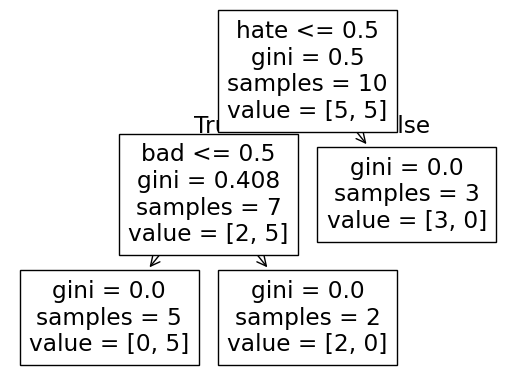

In [97]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

X = dt_with_counts[vocabulary]
print(X)
y = dt_with_counts["sentiment"].values

classifier = DecisionTreeClassifier(random_state=123, max_leaf_nodes=3)
classifier.fit(X, y)
# print(unique_words)
print("Classifier classes:", classifier.classes_)

plot_tree(classifier, feature_names=X.columns)

## Numerical Representations of Text

As we have seen until now, we generally cannot work with text data directly using machine learning algorithms. We need to convert the text into numerical representations first. But this raises several questions:

- How to represent text numerically? Our current approach relies on counting words but is this the best way?
- What information to keep and what to discard?
- How to evaluate the quality of the representation?

Our first approach will be the Bag-of-Words (BoW) model but we want to preview the more modern approaches as well.

The recent advances in large language models (LLMs) based on transformer architectures have turned out to be very successful in a wide range of natural language processing tasks (you are likely talking to some form of a transformer almost every day!).

These models run on numerical representations of tokens (think about words for now) called embeddings. For example, we can assign each word a vector of 3 numbers (3-dimensional embedding). This is not useful in practice but is easy to visualize.

The reason why embeddings are useful is that they fit very well with the computer 
hardware which is designed to work with numbers (addition, multiplication, etc.).

In [99]:
import numpy as np
from plotly.subplots import make_subplots

import plotly.graph_objects as go

# Words given
words = ["dog", "cat", "plane", "air"]

e_dog = np.array([0.1, 0.2, 0.3])
e_cat = np.array([0.15, 0.25, 0.35])
e_plane = np.array([0.7, 0.8, 0.9])
e_air = np.array([0.4, 0.5, 0.8])

embeddings = np.array([e_dog, e_cat, e_plane, e_air])
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
fig.add_trace(
    go.Scatter3d(
        x=embeddings[:, 0],
        y=embeddings[:, 1],
        z=embeddings[:, 2],
        mode='markers+text',
        text=words,
        textposition='top center',
        marker=dict(
            size=8,
            color='blue',
            opacity=0.8
        )
    ),
    row=1, col=1
)

fig.update_layout(
    title="3D Word Embeddings: a dog, a cat, and a plane in the air",
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3',
        xaxis=dict(nticks=10, range=[-1, 1]),
        yaxis=dict(nticks=10, range=[-1, 1]),
    )
)

fig.show()

Let's look a pre-trained word embedding model called GloVe (Global Vectors for Word Representation) developed by Stanford University [@pennington-etal-2014-glove]. There are several versions of GloVe with different dimensionalities (50, 100, 200, 300). At the beginning for this file we have already downloaded the 50 and 100 dimensional versions. We want to test how well these embeddings capture semantic relationships between words.

In [105]:
wv50["boyko"]

array([-0.63864  ,  0.55225  , -0.02868  ,  1.4372   ,  0.84621  ,
        0.086462 ,  1.0269   , -0.15749  , -1.7303   ,  0.78138  ,
        0.97081  ,  0.28231  ,  0.80014  ,  0.30619  ,  0.51364  ,
        0.71541  ,  0.13712  ,  0.15678  ,  0.070215 ,  0.73268  ,
        0.43494  , -0.69873  , -0.48352  , -0.0078218,  0.092079 ,
        0.24763  ,  1.3196   ,  0.20335  , -0.56744  ,  0.087805 ,
       -1.2117   ,  0.77176  ,  0.51919  , -0.45287  , -0.542    ,
        0.44883  ,  0.71517  ,  0.068222 , -0.25429  ,  0.44027  ,
        0.46519  ,  1.036    , -0.80562  , -0.56505  ,  0.38988  ,
       -0.55556  , -0.92507  ,  0.1579   ,  1.5758   , -0.38589  ],
      dtype=float32)

In [106]:
from sklearn.decomposition import PCA

# Get the 100-dimensional embeddings for the words from wv100
words_to_plot = ["dog", "cat", "plane", "air"]
embeddings_100d = np.array([wv100[word] for word in words_to_plot])

# Use PCA to reduce from 100 dimensions to 3 dimensions for visualization

pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings_100d)

# Create 3D scatter plot
fig_wv100 = go.Figure(data=[go.Scatter3d(
    x=embeddings_3d[:, 0],
    y=embeddings_3d[:, 1],
    z=embeddings_3d[:, 2],
    mode='markers+text',
    text=words_to_plot,
    textposition='top center',
    marker=dict(
        size=8,
        color='blue',
        opacity=0.8
    )
)])

fig_wv100.update_layout(
    title="3D Projection of GloVe-100 Word Embeddings",
    scene=dict(
        xaxis_title='PC 1',
        yaxis_title='PC 2',
        zaxis_title='PC 3',
        xaxis=dict(nticks=10, range=[-4, 4]),
        yaxis=dict(nticks=10, range=[-4, 4]),
        zaxis=dict(nticks=10, range=[-4, 4]),
    )
)

fig_wv100.show()

The reason why vector representations of words are so useful is that we can easily perform mathematical operations with them. For example, we can add and subtract vectors, we can measure similarities between them (using cosine similarity, for example), etc.

In [113]:
wv100["uncle"] - wv100["man"] + wv100["woman"]

array([ 6.38110042e-01, -7.76199698e-02,  3.38160008e-01,  3.02094012e-01,
        1.48825794e-01,  1.00976992e+00, -5.54409981e-01, -7.13069737e-02,
        1.11689985e-01, -2.94230014e-01, -4.39969987e-01,  2.07439989e-01,
        4.04479980e-01,  4.98520017e-01,  1.99169993e-01, -5.49869061e-01,
        3.64199877e-02, -1.46899998e-01, -4.48220015e-01,  7.72170007e-01,
       -7.84291029e-01,  6.43920004e-02,  4.27118987e-01,  5.29929996e-01,
        1.16329998e-01, -7.05060363e-02, -9.24950063e-01, -1.87159991e+00,
        6.27029955e-01,  5.08570015e-01,  3.32423985e-01,  6.91089988e-01,
        1.52393401e+00, -3.51750016e-01, -6.35850012e-01,  3.99290025e-01,
        1.35438025e-01, -1.39069974e-01,  8.87390018e-01, -2.89150178e-02,
       -7.55699873e-02,  5.50137043e-01,  7.64997303e-03, -7.18330026e-01,
        2.68040001e-01, -6.52755946e-02, -8.79854977e-01,  2.45618001e-01,
        4.44469988e-01, -3.63889992e-01, -5.27029991e-01,  2.19989985e-01,
        9.34850037e-01,  

In [116]:
wv100["aunt"]

array([ 0.20861  , -0.16902  ,  0.33447  ,  0.043482 , -0.27338  ,
        0.53489  , -0.34282  ,  0.10549  ,  0.29764  , -0.0047136,
       -0.039522 ,  0.17831  , -0.12561  ,  0.46411  ,  0.048369 ,
       -0.082772 ,  0.10357  , -0.052958 , -0.21689  ,  1.1943   ,
       -0.18743  ,  0.69135  ,  0.29401  ,  0.45871  ,  0.41993  ,
        0.33171  , -1.0771   , -1.419    , -0.20005  ,  0.63959  ,
        0.30314  ,  0.51684  ,  1.4939   ,  0.097429 , -0.64012  ,
        0.67043  ,  0.27266  ,  0.14156  ,  0.87618  , -0.0049375,
       -0.066969 ,  0.22421  ,  0.029059 , -0.50297  ,  0.12929  ,
        0.31207  , -0.95988  ,  0.098352 ,  0.72619  , -0.34323  ,
       -0.10229  ,  0.38255  ,  1.5315   ,  0.38464  , -0.18369  ,
       -0.7087   , -0.60978  ,  0.10066  , -0.81362  ,  0.21249  ,
        0.25147  ,  0.96788  ,  0.2786   , -0.28582  ,  0.30714  ,
        0.022422 , -0.20459  ,  0.096513 ,  0.17629  , -0.29374  ,
       -0.40988  , -0.17367  , -0.064264 , -0.31721  ,  0.3849

In [115]:
# Analogy: uncle - man + woman
analogy_results100 = wv100.most_similar(positive=['uncle', 'woman'], negative=['man'], topn=10)
print(analogy_results100)


[('aunt', 0.8368030190467834), ('daughter', 0.8227197527885437), ('niece', 0.8220989108085632), ('grandmother', 0.8220454454421997), ('mother', 0.8078984022140503), ('wife', 0.7898010015487671), ('cousin', 0.7828284502029419), ('granddaughter', 0.7685597538948059), ('father', 0.7636010050773621), ('husband', 0.7516083717346191)]


In [ ]:
# Analogy: uncle - man + woman
analogy_results100 = wv100.most_similar(positive=['uncle', 'woman'], negative=['man'], topn=10)
print(analogy_results100)

[('aunt', 0.8368030190467834), ('daughter', 0.8227197527885437), ('niece', 0.8220989108085632), ('grandmother', 0.8220454454421997), ('mother', 0.8078984022140503), ('wife', 0.7898010015487671), ('cousin', 0.7828284502029419), ('granddaughter', 0.7685597538948059), ('father', 0.7636010050773621), ('husband', 0.7516083717346191)]


## Why vector representations?

- They fit well with computer hardware designed to work with numbers and there exist efficient implementations for vector operations.
- There are many mathematical operations that we can perform with vectors (addition, subtraction, measuring similarity, etc.)


### Basic Operations with Vectors

Embed a local video:

{{< video videos/VectorMovement.mp4 >}}

### Vector Magnitude

While the direction of a vector is an instruction of where to go, the magnitude (length) of the vector tells us how far to go in that direction.
We can compute it by using the Pythagorean theorem (extended to multiple dimensions). With two dimensions we have for the $v = (1, 2)^T$ vector:

$$
||v|| = \sqrt{1^2 + 2^2} = \sqrt{5} \approx 2.236
$$


### Vector Similarity


We consider two vectors to be similar if they point in similar directions. One way to measure this is to compute the cosine of the angle between them. This is called cosine similarity. The cosine theorem is an extension of the Pythagorean theorem and states that in a triangle with sides of lengths a, b and c and angle γ opposite to side c it holds that:

$$
c^2 = a^2 + b^2 - 2ab\cos(\theta)
$$

It can be extended to show the relation between the cosine between two vectors and their dot product.

$$
\cos(\theta) = \frac{u \cdot v}{||u|| \, ||v||}
$$

The cosine of any angle is restricted between -1 and 1 so you can think about it as the percentage of similarity between the directions in which the two vectors point. If the cosine is 1, the vectors point in the same direction, if it is -1 they point in opposite directions and if it is 0 they are orthogonal (perpendicular).

The dot product of two vectors is simply the sum of the products of their corresponding entries (so it is only defined for vectors of the same length).

For example:

$$
u = \begin{pmatrix} 1 \\ 2 \\ 3 \end{pmatrix}, \quad v = \begin{pmatrix} 1 \\ -1 \\ 0 \end{pmatrix} \quad \Rightarrow \quad u \cdot v = 1 \cdot 1 + 2 \cdot (-1) + 3 \cdot 0 = -1
$$

By the way, we can also view the dot product as the matrix multiplication of a 1 x n matrix (row vector) with an n x 1 matrix (column vector).

$$
u^T v = \begin{pmatrix} 1 & 2 & 3 \end{pmatrix} \begin{pmatrix} 1 \\ -1 \\ 0 \end{pmatrix} = -1
$$

To find the cosine of the two vectors we need their magnitudes as well:

$$
||u|| = \sqrt{1^2 + 2^2 + 3^2} = \sqrt{14} \approx 3.742
$$

$$
||v|| = \sqrt{1^2 + (-1)^2 + 0^2} = \sqrt{2} \approx 1.414
$$

Now we are ready to compute the cosine:

$$
\cos(\theta) = \frac{-1}{3.742 \cdot 1.414} \approx -0.189
$$

In [68]:
# The same with numpy

import numpy as np

u = np.array([1, 2, 3])
v = np.array([1, -1, 0])

dot_product = np.dot(u, v)
print(f"Dot product of u and v: {dot_product}")

Dot product of u and v: -1


In [69]:
# The lengths (magnitudes) are

print(f"Length of u: {np.linalg.norm(u).round(3)}")
print(f"Length of v: {np.linalg.norm(v).round(3)}")

Length of u: 3.742
Length of v: 1.414


In [70]:
# So the cosine similarity is

cosine_similarity = dot_product / (np.linalg.norm(u) * np.linalg.norm(v))
print(f"Cosine similarity between u and v: {cosine_similarity.round(3)}")

Cosine similarity between u and v: -0.189


In [72]:
# Is it the same as the correlation?

np.corrcoef(u, v)

array([[ 1. , -0.5],
       [-0.5,  1. ]])

The correlation between two vectors is actually defined quite similarly.

$$
\rho_{u,v} = \frac{\sum_{i=1}^{n} (u_i - \bar{u})(v_i - \bar{v})}{\sqrt{\sum_{i=1}^{n} (u_i - \bar{u})^2} \sqrt{\sum_{i=1}^{n} (v_i - \bar{v})^2}}
$$

When do both coincide?


{{< video videos/CosineSimilarity.mp4 >}}


### Matrix Multiplication

It is also very efficient to perform multiple operations with vectors at one using matrix multiplication.

For machine learning and especially neural networks it is important to develop some intuition about these operations.

Let's see for example how we can interpret the dot product and cosine similarity using numpy.

$$
\begin{pmatrix}
1.95583 & 1.70 \\
0 & 1
\end{pmatrix} \begin{pmatrix} 1 \\ 2 \\ \end{pmatrix} = \begin{pmatrix} 1.95583 \cdot 1 + 1.70 \cdot 2 \\ 0 \cdot 1 + 1 \cdot 2 \end{pmatrix} = \begin{pmatrix} 5.35583 \\ 2 \end{pmatrix}
$$


In [74]:
# Use numpy to 

x = np.array([1, 2])
M = np.array([[1.95583, 1.70], [0, 1]])

M.dot(x)
M @ x

array([5.35583, 2.     ])

(-1.0, 6.0)

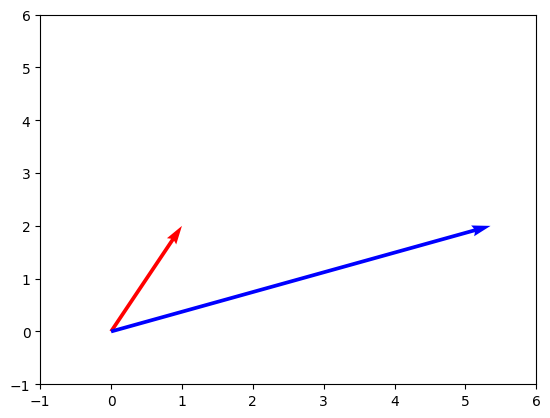

In [76]:
# Plot the vector x and the vector Mx

plt.quiver(0, 0, x[0], x[1], angles='xy', scale_units='xy', scale=1, color='r', label='x')
Mx = M @ x
plt.quiver(0, 0, Mx[0], Mx[1], angles='xy', scale_units='xy', scale=1, color='b', label='Mx')
plt.xlim(-1, 6)
plt.ylim(-1, 6)

## Outline of the Course

1. Bag of Words Models (similar to the last example)
  - Text preprocessing
  - Feature extraction
  - Text classification with classical ML models
  - Extractive Summarization
2. The Bi-Gram Model: an example of a probabilistic language model
3. Neural Word Embeddings
   - Review of Neural Networks
     - Simple perceptron (Linear and Logistic Regression)
     - Simple feedforward networks with one hidden layer and function approximations
     - Multiclass classification with Neural Networks
     - Backpropagation
  - Word2Vec
  - GloVe
4. RNN Language Models
   - Recurrent Neural Networks
   - LSTMs and GRUs
   - Text Generation with RNNs
5. Transformer-based Language Models
   - The attention mechanism
   - Positional encodings
   - The Transformer architecture
6. Applications with pretrained language models
   - Text Classification
   - Text Summarization
   - Fine-tuning transformer models
  